In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
anime = pd.read_csv('../data/anime-recommendations-database/anime.csv')

In [3]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [4]:
print(anime.shape)

(12294, 7)


In [5]:
user = pd.read_csv('../data/anime-recommendations-database/rating.csv')

In [6]:
user.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [7]:
print(user.shape)

(7813737, 3)


In [8]:
# 암시적(implicit) 평가 데이터 제외 (rating=-1)
user = user[user['rating'] != -1]

In [9]:
# 모든 rating 값의 평균

user['rating'].mean()

7.808496946857473

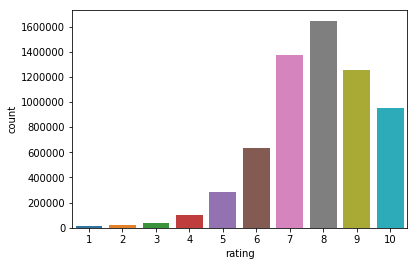

In [10]:
sns.countplot(x='rating', data=user)
plt.show()

In [11]:
# 유저가 평가한 작품 중 고평가를 한 작품만 추출
# 고평가의 기준은 8점 이상을 매긴 작품

user = user[user['rating'] >= 8]
user = user.rename({'rating':'userRating'}, axis='columns')
print(user.shape)

(3855830, 3)


In [12]:
# 메모리 문제로 데이터 사이즈 축소

user = user[user['user_id'] <= 20000]

In [15]:
# 애니메이션 이름 병합
user = pd.merge(user, anime[['anime_id', 'name']], on=['anime_id', 'anime_id'], how='left')
user.head()

,user_id,anime_id,userRating,name
0,1,8074,10,Highschool of the Dead
1,1,11617,10,High School DxD
2,1,11757,10,Sword Art Online
3,1,15451,10,High School DxD New
4,2,11771,10,Kuroko no Basket


In [16]:
user_anime_pivot = user.pivot_table(index='user_id', columns='anime_id', values='userRating', fill_value=0, aggfunc=np.mean)

In [17]:
print(user_anime_pivot.shape)
user_anime_pivot.head(10)

(18726, 7128)


anime_id,1,5,6,7,8,15,16,17,18,19,...,33964,33979,34015,34085,34103,34136,34238,34240,34283,34325
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,8,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# 사용 메모리 축소
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    df = df.astype(np.int8)
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

reduce_mem_usage(user_anime_pivot)

Memory usage of dataframe is 1018.51 MB
Memory usage after optimization is: 127.44 MB
Decreased by 87.5%


anime_id,1,5,6,7,8,15,16,17,18,19,...,33964,33979,34015,34085,34103,34136,34238,34240,34283,34325
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,8,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
